In [1]:
3

3	


In [2]:
require 'dp'
require 'optim'
require 'cunn'
require 'TrainHelpers'
require 'cutorch'
require 'loadcaffe'
require 'cudnn'
require 'inn'

dataPath = paths.concat(dp.DATA_DIR, 'ImageNet')
trainPath = paths.concat(dataPath, 'ILSVRC2012_img_train')
validPath = paths.concat(dataPath, 'ILSVRC2012_img_val')
metaPath = paths.concat(dataPath, 'metadata')

--[[data]]--
ds_all = dp.ImageNet{
   train_path=trainPath, valid_path=validPath, meta_path=metaPath,
   verbose=true,
}
ds_train = ds_all:loadTrain()
ds_valid = ds_all:loadValid()
preprocess = TrainHelpers.normalizePreprocessDataset(ds_train)
sampler = dp.RandomSampler{
    batch_size=128,
    ppf=preprocess
}
ds_train:multithread(4)
sampler:async()
epoch = sampler:sampleEpoch(ds_train)


Loaded mean and std from cache.	


Stats of 100 randomly sampled images after normalizing. Mean: -0.027544820548882 Std: 0.26887162241283	


Starting worker thread with id: 4 seed: 1435178192


Starting worker thread with id: 1 seed: 1435178189


Starting worker thread with id: 2 seed: 1435178190


Starting worker thread with id: 3 seed: 1435178191


In [3]:
batch, i, n = epoch(batch)

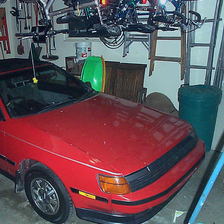

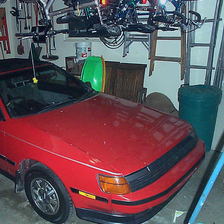

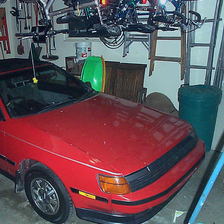

In [3]:
itorch.image(batch:inputs():input()[1])
itorch.image(batch:inputs():input()[1])
itorch.image(batch:inputs():input()[1])

In [ ]:
----------- Caffe first snapshot! ------------------
require 'inn'
--state = torch.load("/mnt/googlenet/alexnet-768000.t7")
--model = state.model

require 'loadcaffe'
cmodel = loadcaffe.load('/mnt/caffe/models/bvlc_alexnet/deploy.prototxt',
    '/mnt/caffe/models/bvlc_alexnet/caffe_alexnet_train_iter_1.caffemodel',
    'cudnn')
-- Replace SoftMax with LogSoftMax
cmodel.modules[#cmodel.modules] = nil
cmodel:add(nn.LogSoftMax():cuda())

In [4]:
---------- My own model! -------------
model = nn.Sequential()
model:add(cudnn.SpatialConvolution(3,96,11,11,4,4,2,2))       -- 224 -> 55
    model.modules[#model.modules].weight:normal(0, 0.01)
    model.modules[#model.modules].bias:fill(0)
model:add(cudnn.ReLU())
model:add(inn.SpatialCrossResponseNormalization(5, 0.0001, 0.75, 1))
model:add(nn.SpatialMaxPooling(3,3,2,2))                   -- 55 ->  27
model:add(cudnn.SpatialConvolution(96,256,5,5,1,1,2,2))       --  27 -> 27
    model.modules[#model.modules].weight:normal(0, 0.01)
    model.modules[#model.modules].bias:fill(0.1)
model:add(cudnn.ReLU())
model:add(inn.SpatialCrossResponseNormalization(5, 0.0001, 0.75, 1))
model:add(nn.SpatialMaxPooling(3,3,2,2))                   --  27 ->  13
model:add(cudnn.SpatialConvolution(256,384,3,3,1,1,1,1))      --  13 ->  13
    model.modules[#model.modules].weight:normal(0, 0.01)
    model.modules[#model.modules].bias:fill(0)
model:add(cudnn.ReLU())
model:add(cudnn.SpatialConvolution(384,384,3,3,1,1,1,1))      --  13 ->  13
    model.modules[#model.modules].weight:normal(0, 0.01)
    model.modules[#model.modules].bias:fill(0.1)
model:add(cudnn.ReLU())
model:add(cudnn.SpatialConvolution(384,256,3,3,1,1,1,1))      --  13 ->  13
    model.modules[#model.modules].weight:normal(0, 0.01)
    model.modules[#model.modules].bias:fill(0.1)
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(3,3,2,2))                   -- 13 -> 6

model:add(nn.View(256*6*6))
model:add(nn.Linear(256*6*6, 4096))
    model.modules[#model.modules].weight:normal(0, 0.005)
    model.modules[#model.modules].bias:fill(0.1)
model:add(cudnn.ReLU())
model:add(nn.Dropout(0.5))
model:add(nn.Linear(4096, 4096))
    model.modules[#model.modules].weight:normal(0, 0.005)
    model.modules[#model.modules].bias:fill(0.1)
model:add(cudnn.ReLU())
model:add(nn.Dropout(0.5))
model:add(nn.Linear(4096, 1000))
    model.modules[#model.modules].weight:normal(0, 0.01)
    model.modules[#model.modules].bias:fill(0)
model:add(nn.LogSoftMax())

model:cuda()

# What is the difference between my model and Caffe's model?

In [135]:
print(model)

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> (15) -> (16) -> (17) -> (18) -> (19) -> (20) -> (21) -> (22) -> (23) -> (24) -> output]
  (1): cudnn.SpatialConvolution(in: 3, out: 96, kW: 11, kH: 11, dW: 4, dH: 4)
  (2): cudnn.ReLU
  (3): inn.SpatialCrossResponseNormalization
  (4): nn.SpatialMaxPooling(kW: 3, kH: 3, dW: 2, dH: 2)
  (5): cudnn.SpatialConvolution(in: 96, out: 256, kW: 5, kH: 5)
  (6): cudnn.ReLU
  (7): inn.SpatialCrossResponseNormalization
  (8): nn.SpatialMaxPooling(kW: 3, kH: 3, dW: 2, dH: 2)
  (9): cudnn.SpatialConvolution(in: 256, out: 384, kW: 3, kH: 3)
  (10): cudnn.ReLU
  (11): cudnn.SpatialConvolution(in: 384, out: 384, kW: 3, kH: 3)
  (12): cudnn.ReLU
  (13): cudnn.SpatialConvolution(in: 384, out: 256, kW: 3, kH: 3)
  (14): nn.ReLU
  (15): nn.SpatialMaxPooling(kW: 3, kH: 3, dW: 2, dH: 2)
  (16): nn.View
  (17): nn.Linear(9216 -> 4096)
  (18): cudnn.ReLU
  (19): nn.Dropout(0.50000

       output : CudaTensor - empty
        }
      3 : 
        inn.SpatialCrossResponseNormalization
        {
          alpha : 0.0001
          scale : CudaTensor - empty
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          size : 5
          k : 1
          beta : 0.75
        }
      4 : 
        nn.SpatialMaxPooling(kW: 3, kH: 3, dW: 2, dH: 2)
        {
          dH : 2
          dW : 2
          kW : 3
          gradInput : CudaTensor - empty
          indices : CudaTensor - empty
          output : CudaTensor - empty
          kH : 3
        }
      5 : 
        cudnn.SpatialConvolution(in: 96, out: 256, kW: 5, kH: 5)
        {
          padW : 2
          nInputPlane : 96
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          iSize : LongStorage - size: 4
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 256
          padH : 2
          kH : 5
          finput : CudaTensor - emp

  output : CudaTensor - empty
          gradInput : CudaTensor - empty
          size : 5
          k : 1
          beta : 0.75
        }
      8 : 
        nn.SpatialMaxPooling(kW: 3, kH: 3, dW: 2, dH: 2)
        {
          dH : 2
          dW : 2
          kW : 3
          gradInput : CudaTensor - empty
          indices : CudaTensor - empty
          output : CudaTensor - empty
          kH : 3
        }
      9 : 
        cudnn.SpatialConvolution(in: 256, out: 384, kW: 3, kH: 3)
        {
          padW : 1
          nInputPlane : 256
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          iSize : LongStorage - size: 4
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 384
          padH : 1
          kH : 3
          finput : CudaTensor - empty
          weight : CudaTensor - size: 384x256x3x3
          fgradInput : CudaTensor - empty
          gradWeight : CudaTensor - size: 384x256x3x3
          kW : 3
          padd

          iSize : LongStorage - size: 4
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 384
          padH : 1
          kH : 3
          finput : CudaTensor - empty
          weight : CudaTensor - size: 384x384x3x3
          fgradInput : CudaTensor - empty
          gradWeight : CudaTensor - size: 384x384x3x3
          kW : 3
          padding : 0
          bias : CudaTensor - size: 384
          gradBias : CudaTensor - size: 384
        }
      12 : 
        cudnn.ReLU
        {
          gradInput : CudaTensor - empty
          mode : CUDNN_ACTIVATION_RELU
          inplace : false
          output : CudaTensor - empty
        }
      13 : 
        cudnn.SpatialConvolution(in: 384, out: 256, kW: 3, kH: 3)
        {
          padW : 1
          nInputPlane : 384
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          iSize : LongStorage - size: 4
          groups : 1
          dH : 1
          dW : 1
          nOutputPl

 output : CudaTensor - empty
          gradInput : CudaTensor - empty
        }
      15 : 
        nn.SpatialMaxPooling(kW: 3, kH: 3, dW: 2, dH: 2)
        {
          dH : 2
          dW : 2
          kW : 3
          gradInput : CudaTensor - empty
          indices : CudaTensor - empty
          output : CudaTensor - empty
          kH : 3
        }
      16 : 
        nn.View
        {
          size : LongStorage - size: 1
          numElements : 9216
        }
      17 : 
        nn.Linear(9216 -> 4096)
        {
          gradBias : CudaTensor - size: 4096
          weight : CudaTensor - size: 4096x9216
          bias : CudaTensor - size: 4096


          gradInput : CudaTensor - empty
          gradWeight : CudaTensor - size: 4096x9216
          output : CudaTensor - empty
        }
      18 : 
        cudnn.ReLU
        {
          gradInput : CudaTensor - empty
          mode : CUDNN_ACTIVATION_RELU
          inplace : false
          output : CudaTensor - empty
        }
      19 : 
        nn.Dropout(0.500000)
        {
          v2 : true
          noise : CudaTensor - empty
          train : true
          p : 0.5
          gradInput : CudaTensor - empty
          output : CudaTensor - empty
        }
      20 : 
        nn.Linear(4096 -> 4096)
        {
          gradBias : CudaTensor - size: 4096
          weight : CudaTensor - size: 4096x4096
          bias : CudaTensor - size: 4096
          gradInput : CudaTensor - empty
          gradWeight : CudaTensor - size: 4096x4096
          output : CudaTensor - empty
        }
      21 : 
        cudnn.ReLU
        {
          gradInput : CudaTensor - empty
          mode 

        }
      24 : 
        nn.LogSoftMax
        {
          gradInput : CudaTensor - empty
          output : CudaTensor - empty
        }
    }
  output : CudaTensor - empty
}


In [ ]:
loss_log = {}
for _,i in ipairs(state.lossLog) do
    table.insert(loss_log, i.loss)
end

itorch:Plot():line(torch.range(1,#loss_log), torch.Tensor(loss_log)):draw()

In [ ]:
for i=1,#model.modules do
    if model.modules[i].gradWeight then
        collectgarbage(); collectgarbage();
        print("Module "..i.." grad weights, L1 norm: ", model.modules[i].gradWeight:clone():abs():sum())
        --print("Module "..i.." grad bias, L1 norm: ", model.modules[i].gradBias:clone():abs():sum())
        print("Module "..i.." weights, L1 norm: ", model.modules[i].weight:clone():abs():sum())
    end
end


# Let AlexNet converge! !!!

In [5]:
epoch = sampler:sampleEpoch(ds_train)

weights, gradients = model:getParameters()

In [6]:
criterion = nn.ClassNLLCriterion()
criterion:cuda()

In [7]:
loss_log = {}

In [8]:
sgdState = {learningRate = 0.01, momentum=0.9, dampening=0, weightDecay=0.0005}

-- Turn on nesterov momentum!
sgdState = {learningRate = 0.01, momentum=0.9, dampening=0, weightDecay=0.0005, nesterov=true}

In [9]:
for batchnum=1,2000 do
    batch,i,n = epoch(batch)
    if not batch then
        break
    end
    
    collectgarbage(); collectgarbage()
    gradients:zero()
    --batch = ds_train:batch(100)
    local inputs = batch:inputs():input():cuda()
    local targets = batch:targets():input():cuda()
    
    -- caffe models expect 0-255, we have 0-1
    inputs:mul(255)
    -- N.B.!!! the image has already been mean-substracted, so
    -- the range is really more like -128 to 128 or so...
    
    local outputs = model:forward(inputs)
    --print("Outputs", outputs[1])
    local loss = criterion:forward(outputs,targets)
    table.insert(loss_log, loss)
    if batchnum % 20 == 0 then
        print("Batch num "..batchnum)
        print("Loss "..loss)
    end
    dfdw = criterion:backward(outputs,targets)
    
    model:backward(inputs, dfdw)
    --print("Gradient L1", gradients:clone():abs():sum())
    --print("Dfdw", dfdw[1])
    --print("Gradients", gradients[{{1,100}}])
    --weights:add(-lr, gradients)
    --model.modules[1].gradWeights:mul(200)
    function eval() return loss, gradients end
    optim.sgd(eval, weights, sgdState)
end

Batch num 20	
Loss 6.90931224823	


Batch num 40	
Loss 6.9349722862244	


Batch num 60	
Loss 6.9294667243958	


Batch num 80	
Loss 6.9138450622559	


Batch num 100	
Loss 6.9257483482361	


Batch num 120	
Loss 6.9176645278931	


Batch num 140	
Loss 6.9020977020264	


Batch num 160	
Loss 6.9060564041138	


Batch num 180	
Loss 6.9238910675049	

Batch num 200	
Loss 6.9078650474548	


Batch num 220	
Loss 6.9044332504272	


Batch num 240	
Loss 6.8911833763123	


Batch num 260	
Loss 6.8823571205139	


Batch num 280	
Loss 6.8763213157654	


Batch num 300	
Loss 6.788387298584	


Batch num 320	
Loss 6.9156169891357	

Batch num 340	
Loss 6.8181939125061	


Batch num 360	
Loss 6.7752633094788	


Batch num 380	
Loss 6.8327088356018	


Batch num 400	
Loss 6.8717708587646	


Batch num 420	
Loss 6.7424941062927	


Batch num 440	
Loss 6.7350730895996	


Batch num 460	
Loss 6.7338528633118	


Batch num 480	
Loss 6.7885127067566	


Batch num 500	
Loss 6.6494917869568	


Batch num 520	
Loss 6.8544778823853	


Batch num 540	
Loss 6.764955997467	


Batch num 560	
Loss 6.7588458061218	


Batch num 580	
Loss 6.6955809593201	


Batch num 600	
Loss 6.7956461906433	


Batch num 620	
Loss 6.5868902206421	


Batch num 640	
Loss 6.6226706504822	


Batch num 660	
Loss 6.7090282440186	


Batch num 680	
Loss 6.675829410553	


Batch num 700	
Loss 6.6427316665649	


Batch num 720	
Loss 6.6543536186218	


Batch num 740	
Loss 6.7098488807678	


Batch num 760	
Loss 6.5933146476746	


Batch num 780	
Loss 6.5876431465149	


Batch num 800	
Loss 6.5277118682861	


Batch num 820	
Loss 6.5528864860535	


Batch num 840	
Loss 6.6374087333679	


Batch num 860	
Loss 6.4052715301514	


Batch num 880	
Loss 6.4849348068237	


Batch num 900	
Loss 6.4846143722534	


Batch num 920	
Loss 6.697172164917	


Batch num 940	
Loss 6.5421781539917	


Batch num 960	
Loss 6.5074496269226	


Batch num 980	
Loss 6.5530767440796	


Batch num 1000	
Loss 6.4392132759094	


Batch num 1020	
Loss 6.3961148262024	


Batch num 1040	
Loss 6.4270696640015	


Batch num 1060	
Loss 6.3279247283936	


Batch num 1080	
Loss 6.3037657737732	


Batch num 1100	
Loss 6.3943710327148	


Batch num 1120	
Loss 6.657301902771	


Batch num 1140	
Loss 6.3686742782593	


Batch num 1160	
Loss 6.133487701416	


Batch num 1180	
Loss 6.2455611228943	


Batch num 1200	
Loss 6.3268203735352	


Batch num 1220	
Loss 6.2383217811584	


Batch num 1240	
Loss 6.3853797912598	


Batch num 1260	
Loss 6.3889493942261	


Batch num 1280	
Loss 6.3208856582642	


Batch num 1300	
Loss 6.2734622955322	


Batch num 1320	
Loss 6.1968808174133	


Batch num 1340	
Loss 6.4759106636047	


Batch num 1360	
Loss 6.3071970939636	


Batch num 1380	
Loss 5.9523863792419	


Batch num 1400	
Loss 6.2518882751465	


Batch num 1420	
Loss 6.2830066680908	


Batch num 1440	
Loss 6.1835584640503	


Batch num 1460	
Loss 6.2106156349182	


Batch num 1480	
Loss 6.0380892753601	


Batch num 1500	
Loss 6.2066702842712	


Batch num 1520	
Loss 6.1536874771118	


Batch num 1540	
Loss 6.3017807006836	


Batch num 1560	
Loss 6.3195457458496	


Batch num 1580	
Loss 6.21488904953	


Batch num 1600	
Loss 5.9045314788818	


Batch num 1620	
Loss 6.0568428039551	


Batch num 1640	
Loss 6.1687631607056	


Batch num 1660	
Loss 6.3235783576965	


Batch num 1680	
Loss 6.0950245857239	


Batch num 1700	
Loss 5.7923226356506	


Batch num 1720	
Loss 6.0184125900269	


Batch num 1740	
Loss 5.9929494857788	


Batch num 1760	
Loss 6.0141315460205	


Batch num 1780	
Loss 6.0281600952148	


Batch num 1800	
Loss 5.9387030601501	


Batch num 1820	
Loss 5.8855857849121	


Batch num 1840	
Loss 5.9536471366882	


Batch num 1860	
Loss 6.0590224266052	


Batch num 1880	
Loss 5.8138861656189	


Batch num 1900	
Loss 5.7282547950745	


Batch num 1920	
Loss 5.9533267021179	


Batch num 1940	
Loss 5.8746089935303	


Batch num 1960	
Loss 6.0540709495544	


Batch num 1980	
Loss 5.9006147384644	


Batch num 2000	
Loss 5.9716110229492	


In [10]:
-- Using my own model, with proper weight initializations, but dropping
-- the LCN layers.
itorch:Plot():line(torch.range(1,#loss_log), torch.Tensor(loss_log)):draw()

{
  _docid : userdata: NULL
  yaxis : function: 0x404e0958
  toTemplate : function: 0x4168ff68
  quad : function: 0x405484d0
  triangle : function: 0x405483a8
  save : function: 0x4053a7b0
  circle : function: 0x40548300
  draw : function: 0x4168fff0
  _simpleGlyph : function: 0x404e09b0
  title : function: 0x40548510
  line : function: 0x40548388
  segment : function: 0x40548490
  histogram : function: 0x405484f0
  _data : 
    {
      1 : 
        {
          fill_color : red
          line_color : red
          legend : unnamed
          type : Line


          y : DoubleTensor - size: 2000
          x : DoubleTensor - size: 2000
        }
    }
  new : function: 0x404e0c00
  _toAllModels : function: 0x4168fe08
  _winid : 3de3aa81-2bc2-4514-c55b-552a597be5ee
  hist : function: 0x405484f0
  xaxis : function: 0x40548530
  redraw : function: 0x4053a790
  quiver : function: 0x405484b0
  legend : function: 0x40548320
  toHTML : function: 0x4168ffb0
}


In [16]:
-- Using my own model with LCN layers, but I commented out all the weight initialization stuff.
-- So this is with Torch default weights.
itorch:Plot():line(torch.range(1,#loss_log), torch.Tensor(loss_log)):draw()

{
  _docid : userdata: NULL
  yaxis : function: 0x42009330
  toTemplate : function: 0x41878060
  quad : function: 0x420092b0
  triangle : function: 0x42009188
  save : function: 0x41878450
  circle : function: 0x406f2768
  draw : function: 0x418783f0
  _simpleGlyph : function: 0x406f2728
  title : function: 0x420092f0
  line : function: 0x406f26d0
  segment : function: 0x42009270
  histogram : function: 0x420092d0
  _data : 
    {
      1 : 
        {
          fill_color : red
          line_color : red
       

   legend : unnamed
          type : Line
          y : DoubleTensor - size: 2000
          x : DoubleTensor - size: 2000
        }
    }
  new : function: 0x406f2690
  _toAllModels : function: 0x4186c488
  _winid : 6761a806-b16f-4d65-cdfb-ac8a32d052d3
  hist : function: 0x420092d0
  xaxis : function: 0x42009310
  redraw : function: 0x41878430
  quiver : function: 0x42009290
  legend : function: 0x42009350
  toHTML : function: 0x418780a8
}


In [141]:
-- Using my own model that I've verified should look exactly like Caffe's.
itorch:Plot():line(torch.range(1,#loss_log), torch.Tensor(loss_log)):draw()

{
  _docid : userdata: NULL
  yaxis : function: 0x403a5588
  toTemplate : function: 0x417b96d8
  quad : function: 0x403a5508
  triangle : function: 0x40480b00
  save : function: 0x4039b568
  circle : function: 0x40480a58
  draw : function: 0x417b9a68
  _simpleGlyph : function: 0x40480a18
  title : function: 0x403a5548
  line : function: 0x40480ae0
  segment : function: 0x40480b20
  histogram : function: 0x403a5528
  _data : 
    {
      1 : 
        {
          fill_color : red
          line_color : red
          legend : unnamed
          type : Line
          y : DoubleTensor - size: 2000


          x : DoubleTensor - size: 2000
        }
    }
  new : function: 0x417db528
  _toAllModels : function: 0x41acb5e0
  _winid : a2ce4f98-354f-47bd-c7ea-27a81d2f5ff4
  hist : function: 0x403a5528
  xaxis : function: 0x403a5568
  redraw : function: 0x4039b548
  quiver : function: 0x403a54e8
  legend : function: 0x403a55a8
  toHTML : function: 0x417b9720
}


In [12]:
-- Using Caffe initializations.
-- (This model is 'loadcaffe', snapshotted after a single Caffe batch forward+backward pass, so
-- it should be pretty close to pristine)
itorch:Plot():line(torch.range(1,#loss_log), torch.Tensor(loss_log)):draw()

{
  _docid : userdata: NULL
  yaxis : function: 0x41a71b60
  toTemplate : function: 0x40097070
  quad : function: 0x41cdf960
  triangle : function: 0x41cdf838
  save : function: 0x40097158
  circle : function: 0x41a71b40
  draw : function: 0x400970f8
  _simpleGlyph : function: 0x41a81598
  title : function: 0x41cdf9a0
  line : function: 0x41a81540
  segment : function: 0x41cdf920
  histogram : function: 0x41cdf980
  _data : 
    {
      1 : 
        {
          fill_color : red
          line_color : red
          legend : unnamed
          type : Line
          y : DoubleTensor - size: 4000
          x : DoubleTensor - size: 4000
        }
    }
  new : function: 0x41a81500
  _toAllModels : function: 0x41a75718
  _winid : 7e53a95b-08ef-4339-c32e-16902ef9f67f
  hist : function: 0x41cdf980
  xaxis : function: 0x41cdf9c0
  redraw : function: 0x40097138
  quiver : function: 0x41cdf940
  legend : function: 0x41a71b80
  toHTML : function: 0x400970b8
}


In [19]:
-- Left: Caffe initialization. Right: Torch defaults.
itorch:Plot():line(torch.range(1,#loss_log), torch.Tensor(loss_log)):draw()

{
  _docid : userdata: NULL
  yaxis : function: 0x40943940
  toTemplate : function: 0x4092bf20
  quad : function: 0x4092e9a0
  triangle : function: 0x405d57e8
  save : function: 0x4092c008
  circle : function: 0x41b37c10
  draw : function: 0x4092bfa8
  _simpleGlyph : function: 0x41b37bd0
  title : function: 0x40943900
  line : function: 0x41b37b78
  segment : function: 0x405d5808
  histogram : function: 0x4092e9c0
  _data : 
    {
      1 : 
        {
          fill_color : red
          line_color : red
          legend : unnamed
          type : Line
          y : DoubleTensor - size: 4000
          x : DoubleTensor - size: 4000
        }
    }
  new : function: 0x41b37b38
  _toAllModels : function: 0x4092bdc0
  _winid : 7f26662f-9866-430e-c3cb-5a97b8db7579
  hist : function: 0x4092e9c0
  xaxis : function: 0x40943920
  redraw : function: 0x4092bfe8
  quiver : function: 0x4092e980
  legend : function: 0x40943960
  toHTML : function: 0x4092bf68
}


In [12]:
-- Using Caffe initializations
itorch:Plot():line(torch.range(1,#loss_log), torch.Tensor(loss_log)):draw()

}
  new : function: 0x41b37b38
  _toAllModels : function: 0x4092bdc0
  _winid : c77fc70e-c027-4bdd-cb74-9efe64b30c3f
  hist : function: 0x4092e9c0
  xaxis : function: 0x40943920
  redraw : function: 0x4092bfe8
  quiver : function: 0x4092e980
  legend : function: 0x40943960
  toHTML : function: 0x4092bf68
}


{
  _docid : userdata: NULL
  yaxis : function: 0x40943940


  toTemplate : function: 0x4092bf20
  quad : function: 0x4092e9a0
  triangle : function: 0x405d57e8
  save : function: 0x4092c008
  circle : function: 0x41b37c10
  draw : function: 0x4092bfa8
  _simpleGlyph : function: 0x41b37bd0
  title : function: 0x40943900
  line : function: 0x41b37b78
  segment : function: 0x405d5808
  histogram : function: 0x4092e9c0
  _data : 
    {
      1 : 
        {
          fill_color : red
          

line_color : red
          legend : unnamed
          type : Line
          y : DoubleTensor - size: 2000
          x : DoubleTensor - size: 2000
        }
    }
  new : function: 0x41b37b38
  _toAllModels : function: 0x4092bdc0
  _winid : 7e53a95b-08ef-4339-c32e-16902ef9f67f
  hist : function: 0x4092e9c0
  xaxis : function: 0x40943920
  redraw : function: 0x4092bfe8
  quiver : function: 0x4092e980
  legend : function: 0x40943960
  toHTML : function: 0x4092bf68
}


In [79]:
itorch:Plot():line(torch.range(1,#loss_log), torch.Tensor(loss_log)):draw()

{
  _docid : userdata: NULL
  yaxis : function: 0x40438de8
  toTemplate : function: 0x4042f548
  quad : function: 0x40438d68
  triangle : function: 0x40438c40
  save : function: 0x4042f630
  circle : function: 0x40ccc3b0
  draw : function: 0x4042f5d0
  _simpleGlyph : function: 0x40ccc370
  title : function: 0x40438da8
  line : function: 0x40438c20
  segment : function: 0x40438d28
  histogram : function: 0x40438d88
  _data : 
    {
      1 : 
        {
          fill_color : red
          line_color : red
          legend : unnamed
          type : Line
          y : DoubleTensor - size: 4300


          x : DoubleTensor - size: 4300
        }
    }
  new : function: 0x40ccc2d8
  _toAllModels : function: 0x412a7058
  _winid : 1c8337bd-fb23-4d0d-cdc5-202df5c697cc
  hist : function: 0x40438d88
  xaxis : function: 0x40438dc8
  redraw : function: 0x4042f610
  quiver : function: 0x40438d48
  legend : function: 0x40438e08
  toHTML : function: 0x4042f590
}


In [27]:
for i=1,#model.modules do
    if model.modules[i].gradWeight then
        collectgarbage(); collectgarbage();
        print("Module "..i.." grad weights, mean: ", model.modules[i].gradWeight:clone():abs():mean())
        --print("Module "..i.." grad bias, L1 norm: ", model.modules[i].gradBias:clone():abs():sum())
        print("Module "..i.." weights, mean: ", model.modules[i].weight:clone():abs():mean())
    end
end


Module 1 grad weights, mean: 	0.00068742042640224	
Module 1 weights, mean: 	0.0079163182526827	


Module 5 grad weights, mean: 	0.0002710496482905	
Module 5 weights, mean: 	0.0079695051535964	


Module 9 grad weights, mean: 	0.0001438722392777	
Module 9 weights, mean: 	0.007980520837009	


Module 11 grad weights, mean: 	0.00013664193102159	
Module 11 weights, mean: 	0.0079779010266066	


Module 13 grad weights, mean: 	0.00019328408234287	


Module 13 weights, mean: 	0.0079777259379625	


Module 17 grad weights, mean: 	6.2982537201606e-05	


Module 17 weights, mean: 	0.003988835029304	


Module 20 grad weights, mean: 	0.00013965877587907	


Module 20 weights, mean: 	0.0039894785732031	


Module 23 grad weights, mean: 	0.0001742385502439	
Module 23 weights, mean: 	0.0079804537817836	


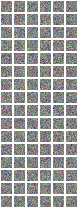

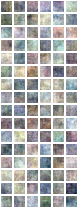

In [28]:
itorch.image(model.modules[1].weight)
itorch.image(model.modules[1].gradWeight)

In [29]:
model.modules[1].gradWeight:max()

0.0024989177472889	


In [15]:
itorch.image(inputs)

/home/ubuntu/torch/install/share/lua/5.1/itorch/gfx.lua:49: unhandled type in itorch.image:nil
stack traceback:
	[C]: in function 'error'
	/home/ubuntu/torch/install/share/lua/5.1/itorch/gfx.lua:49: in function 'f'
	[string "local f = function() return itorch.image(inpu..."]:1: in main chunk
	[C]: in function 'xpcall'
	/home/ubuntu/torch/install/share/lua/5.1/itorch/main.lua:177: in function </home/ubuntu/torch/install/share/lua/5.1/itorch/main.lua:143>
	/home/ubuntu/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/home/ubuntu/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/home/ubuntu/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/home/ubuntu/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/home/ubuntu/torch/install/share/lua/5.1/itorch/main.lua:344: in main chunk
	[C]: in function 'require'
	[string "arg={'/home/ubuntu/.ipython/profile_default/s..."]:1: in main chunk: 

# Test on CIFAR

In [1]:
3 

3	


In [2]:
require 'dp'
require 'optim'
require 'cunn'
require 'TrainHelpers'
require 'cutorch'
require 'loadcaffe'
require 'cudnn'

ds_all = dp.Cifar10{input_preprocess=dp.Standardize()}
ds_train = ds_all:loadTrain()
--ds_valid = ds_all:loadValid()
ds_test = ds_all:loadTest()

In [3]:
ds_train._data_path =  {"/tmp"}
sampler = dp.ShuffleSampler{
    batch_size=20,
}
--ds_train:multithread(4)
--sampler:async()
epoch = sampler:sampleEpoch(ds_train)
batch,i,n = epoch(batch)

In [4]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(3, 6, 5, 5)) -- 1 input image channel, 6 output channels, 5x5 convolution kernel
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.Linear(120, 84))
net:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())                     -- converts the output to a log-probability. Useful for classification problems

criterion = nn.ClassNLLCriterion()

print('Lenet5\n' .. net:__tostring());

In [33]:
net:reset()
weights,gradients = net:getParameters() -- be sure to do this AFTER CUDA-izing it!
gradients:zero()
lr = 0.1
net:training()
sgdState = {learningRate = lr, momentum = 0.9 } --, dampening=0, nesterov=true}

loss_log = {}

In [36]:

epoch = sampler:sampleEpoch(ds_train)

while true do
    batch,i,n = epoch(batch)
    if not batch then
        break
    end
    
    gradients:zero()
    --batch = ds_train:batch(100)
    inputs = batch:inputs():input()
    targets = batch:targets():input()
    outputs = net:forward(inputs)
    --print("Outputs", outputs[1])
    loss = criterion:forward(outputs,targets)
    table.insert(loss_log, loss)
    --print("Loss", loss)
    dfdw = criterion:backward(outputs,targets)
    
    net:backward(inputs, dfdw)
    --print("Gradient L1", gradients:clone():abs():sum())
    --print("Dfdw", dfdw[1])
    --print("Gradients", gradients[{{1,100}}])
    --weights:add(-lr, gradients)   
    function eval() return loss, gradients end
    optim.sgd(eval, weights, sgdState)
end
    

In [37]:
plot = itorch:Plot():line(torch.range(1, #loss_log), torch.Tensor(loss_log)):draw()

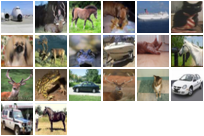

In [30]:
itorch.image(inputs)

In [21]:
local correct = 0
local total = 0

epoch = dp.ShuffleSampler{
    batch_size=20,
}:sampleEpoch(ds_test)

while true do
    batch,i,n = epoch(batch)
    if not batch then
        break
    end
    
    inputs = batch:inputs():input()
    targets = batch:targets():input()
    total = total + targets:size(1)
    outputs = net:forward(inputs)
    conf, indices = torch.sort(outputs, true)
    --print(#indices)
    correct = correct + indices:select(2,1):clone():int():eq(targets:clone():int()):sum()    
end
print("Correct: "..correct.."/"..total.." Accuracy: ".. (correct/total))
    

Correct: 5243/10000 Accuracy: 0.5243	


In [31]:
itorch.image(net.modules[1].weight)

In [32]:
net.modules[1].weight

(1,1,.,.) = 
  0.1055  0.3990  0.4707  0.3587  0.1095
  0.2014  0.4644  0.4202  0.1939  0.0374
  0.1394  0.0868 -0.0580 -0.1553 -0.1110
 -0.1462 -0.2525 -0.3846 -0.3303 -0.2334
 -0.0499 -0.1732 -0.1372  0.0093 -0.0948

(2,1,.,.) = 
  0.1956  0.0745 -0.0358  0.2263  0.2507
  0.1023  0.0535 -0.1862  0.0877  0.3005
  0.3085 -0.1674 -0.5480  0.1313  0.1606
  0.3493 -0.0346 -0.5271 -0.0674  0.1843
  0.1379  0.0885 -0.2779 -0.2388 -0.0411

(3,1,.,.) = 
 -0.1528 -0.0001 -0.0291 -0.1847 -0.1925
  0.0666  0.0700  0.0088 -0.2191 -0.2752
  0.0692 -0.0339  0.2741  0.0819 -0.1522
  0.1507  0.0269  0.2399  0.1045  0.2320
  0.1926  0.2434  0.0973  0.1723  0.2144

(4,1,.,.) = 
 -0.0336 -0.1345 -0.3588 -0.4434 -0.0630
 -0.1140 -0.1813 -0.4707 -0.1105  0.0910
 -0.2598 -0.3116 -0.1021  0.0029 -0.1493
 -0.2254 -0.1837  0.0919 -0.0461  0.0076
 -0.0978  0.0347 -0.0146 -0.0127 -0.0783

(5,1,.,.) = 
  0.0674  0.1262  0.2510  0.3005  0.2065
  0.0366  0.0881  0.0399  0.0918  0.1952
 -0.1703 -0.1930 -0.2715 -0.1